### 使用 RNN 进行自回归语言学习

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

e:\Anaconda\envs\project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1、RNN 模型

In [3]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden=None):
        # input:  (B, T, C)
        # hidden: (B,    H)
        # out:    (B, T, H)
        B, T, C = input.shape
        re = []
        if hidden is None:
            hidden = self.init_hidden(B, input.device)
        for i in range(T):
            combined = torch.concat((input[:, i, :], hidden), dim=-1)  # (B, C + H)
            hidden = F.relu(self.i2h(combined))
            re.append(hidden)
        return torch.stack(re, dim=1)                                  # (B, T, H)

    def init_hidden(self, B, device):
        return torch.zeros((B, self.hidden_size), device=device)

In [4]:
class CharRNNBatch(nn.Module):

    def __init__(self, vs):
        super().__init__()
        emb_size = 256
        hidden_size = 128
        self.emb = nn.Sequential(
            nn.Embedding(vs, emb_size),
            nn.LayerNorm(emb_size)
        )
        #RNN不需要截距项
        self.rnn1 = RNN(emb_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.rnn2 = RNN(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.lm = nn.Linear(hidden_size, vs)
        self.dp = nn.Dropout(0.4)

    def forward(self, x):
        # x: (B, T)
        # 暂不实现初始隐藏状态的输入
        B = x.shape[0]
        embeddings = self.emb(x)   # (B, T, emb_size)
        h = F.relu(self.ln1(self.rnn1(embeddings)))  # (B, T, hidden_size)
        h = self.dp(h)
        h = F.relu(self.ln2(self.rnn2(h)))           # (B, T, hidden_size)
        h = self.dp(h)
        out = self.lm(h)                             # (B, T, vs)
        return out

#### 2、超参数定义

In [5]:
# 定义超参数
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 1000
lr = 0.0001
eval_iters = 10
sequence_len = 64

#### 3、数据加载

In [6]:
def load_ptb_data(data_dir='data'):
    def read_file(filename):
        with open(filename, 'r', encoding='utf-8') as f:
            return [line.strip() for line in f if line.strip()]

    train_data = read_file(f'{data_dir}/ptb.train.txt')
    valid_data = read_file(f'{data_dir}/ptb.valid.txt')
    test_data  = read_file(f'{data_dir}/ptb.test.txt')
    
    return train_data, valid_data, test_data

train_data, valid_data, test_data = load_ptb_data()
print("Sample:", train_data[: 10])

Sample: ['aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter', 'pierre <unk> N years old will join the board as a nonexecutive director nov. N', 'mr. <unk> is chairman of <unk> n.v. the dutch publishing group', 'rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate', 'a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported', 'the asbestos fiber <unk> is unusually <unk> once it enters the <unk> with even brief exposures to it causing symptoms that show up decades later researchers said', '<unk> inc. the unit of new york-based <unk> corp. that makes kent cigarettes stopped using <unk> in its <unk> cigarette filters in N', "although prelimin

In [7]:
print(len(train_data))

42068


In [8]:
class CharTokenizer:

    def __init__(self, data, end_ind=0):
        # data: list[str]
        chars = sorted(list(set(''.join(data))))
        self.char2ind = {s: i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = end_ind
        self.ind2char = {v: k for k, v in self.char2ind.items()}
        self.end_ind = end_ind

    def encode(self, x):
        return [self.char2ind[i] for i in x]
    
    def decode(self, x):
        if isinstance(x, int):
            return self.ind2char[x]
        return [self.ind2char[i] for i in x]

#### 4、测试分词器是否正常运行

In [9]:
tokenizer = CharTokenizer(train_data)
test_str = 'there is no'
re = tokenizer.encode(test_str)
print(re)
re = tokenizer.decode(re)
print(''.join(re))
''.join(tokenizer.decode(range(len(tokenizer.char2ind))))

[43, 31, 28, 41, 28, 1, 32, 42, 1, 37, 38]
there is no


"<|e|> #$&'*-./0123456789<>N\\abcdefghijklmnopqrstuvwxyz"

In [10]:
def autoregressive_trans(text, tokenizer, context_length=10):
    # test: str
    inputs, labels = [], []
    eind = tokenizer.end_ind
    enc = tokenizer.encode(text)
    # 增加特殊字符
    data = enc + [eind]
    for i in range(len(data) - context_length):
        inputs.append(data[i: i + context_length])
        labels.append(data[i + context_length])
    return inputs, labels

In [11]:
inputs, labels = autoregressive_trans(test_str, tokenizer, 3)
for a, b in zip(inputs, labels):
    print(f"{''.join(tokenizer.decode(a))}--->{tokenizer.decode(b)}")

the--->r
her--->e
ere---> 
re --->i
e i--->s
 is---> 
is --->n
s n--->o
 no---><|e|>


#### 5、建立模型

In [12]:
c_model = CharRNNBatch(len(tokenizer.char2ind)).to(device)
c_model

CharRNNBatch(
  (emb): Sequential(
    (0): Embedding(50, 256)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (rnn1): RNN(
    (i2h): Linear(in_features=384, out_features=128, bias=True)
  )
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (rnn2): RNN(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
  )
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm): Linear(in_features=128, out_features=50, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
)

In [13]:
# 定义文本生成函数
@torch.no_grad()
def generate(model, context, tokenizer, max_new_tokens=300):
    # context: (1, T)
    #out = []
    out = context.tolist()[0]
    model.eval()
    for _ in range(max_new_tokens):
        #可以考虑截断背景，使得文本生成更加贴近训练
        #logits = model(context[:, -sequence_len:])
        logits = model(context)            # (1, T, 98)
        probs = F.softmax(logits[:, -1, :], dim=-1)  # (1, 98)
        # 随机生成文本
        ix = torch.multinomial(probs, num_samples=1)  # (1, 1)
        # 更新背景
        context = torch.concat((context, ix), dim=-1)
        out.append(ix.item())
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [14]:
context = torch.tensor(tokenizer.encode('def'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

def2#z0q7mv0&tlamgp#jf93h>e9/w1j2dyy1lvahnv0lxebvdvtf38>5g3l$$<|e|>


In [15]:
def process(data, tokenizer, sequence_len=sequence_len):
    text = data
    # text is list[str]
    inputs, labels = [], []
    for t in text:
        enc = tokenizer.encode(t)
        enc += [tokenizer.end_ind]
        # 有bug，无法处理长度过小的数据
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

In [16]:
from datasets import Dataset

hf_train_dataset = Dataset.from_dict({"text": train_data})

In [17]:
print(hf_train_dataset)

Dataset({
    features: ['text'],
    num_rows: 42068
})


In [18]:
# 将数据分为训练集和测试集
tokenized = hf_train_dataset.train_test_split(test_size=0.1, seed=1024, shuffle=True)

f = lambda x: process(x['text'], tokenizer)
tokenized = tokenized.map(f, batched=True, remove_columns=hf_train_dataset.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

Map: 100%|██████████| 4207/4207 [00:04<00:00, 923.02 examples/s]


(torch.Size([2242742, 64]), torch.Size([2242742, 64]))

In [19]:
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)

In [20]:
next(iter(train_loader))

{'inputs': tensor([[ 1, 46, 31,  ..., 38, 44, 43],
         [32, 42,  1,  ..., 38, 45, 28],
         [33, 38, 41,  ..., 25, 43,  1],
         ...,
         [28, 42, 43,  ..., 39, 35, 28],
         [36, 28,  1,  ..., 38, 36, 39],
         [44, 37, 34,  ..., 43, 31, 28]], device='cuda:0'),
 'labels': tensor([[46, 31, 32,  ..., 44, 43,  1],
         [42,  1, 37,  ..., 45, 28, 41],
         [38, 41,  1,  ..., 43,  1, 38],
         ...,
         [42, 43,  1,  ..., 35, 28,  1],
         [28,  1, 25,  ..., 36, 39, 35],
         [37, 34, 21,  ..., 31, 28, 32]], device='cuda:0')}

In [21]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter= iter(data_loader)
    # 随机使用多个批量数据来预估模型效果
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']  # (B, T)
        logits = model(inputs)                           # (B, T, vs)
        # 请参考官方文档
        loss.append(F.cross_entropy(logits.transpose(-2, -1), labels).item())
    return torch.tensor(loss).mean().item()

estimate_loss(c_model)

{'train': 4.0141754150390625, 'test': 4.013864994049072}

In [22]:
from tqdm import tqdm

def train_model(model, optimizer, epochs=5):
    lossi = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        # tqdm 包装 train_loader，显示进度条
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        for i, data in enumerate(pbar, 0):
            inputs, labels = data['inputs'], data['labels']  # (B, T)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(inputs)                           # (B, T, vs)
            loss = F.cross_entropy(logits.transpose(-2, -1), labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            loss_val = loss.item()
            lossi.append(loss_val)
            epoch_loss += loss_val

            # 准确率计算
            preds = torch.argmax(logits, dim=-1)             # (B, T)
            correct = (preds == labels).sum().item()

            # 更新 tqdm 描述信息
            pbar.set_postfix(loss=loss_val,acc=f"{100*correct / labels.numel():.2f}%")

        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'\nEpoch {epoch + 1:>2}: {train_loss}, {test_loss}')
    return lossi


In [24]:
l = train_model(c_model, optim.Adam(c_model.parameters(), lr=lr))

Epoch 1/5: 100%|██████████| 2243/2243 [13:09<00:00,  2.84it/s, acc=48.42%, loss=1.75]



Epoch  1: train loss 1.5879, test loss 1.5835


Epoch 2/5: 100%|██████████| 2243/2243 [13:28<00:00,  2.77it/s, acc=50.10%, loss=1.66]



Epoch  2: train loss 1.4839, test loss 1.4849


Epoch 3/5: 100%|██████████| 2243/2243 [13:34<00:00,  2.75it/s, acc=51.28%, loss=1.62]



Epoch  3: train loss 1.4487, test loss 1.4501


Epoch 4/5: 100%|██████████| 2243/2243 [12:26<00:00,  3.01it/s, acc=51.63%, loss=1.6] 



Epoch  4: train loss 1.4287, test loss 1.4262


Epoch 5/5: 100%|██████████| 2243/2243 [12:55<00:00,  2.89it/s, acc=52.32%, loss=1.58]



Epoch  5: train loss 1.4098, test loss 1.4118


In [25]:
torch.save(c_model.state_dict(), 'RNN_PTB.pth')

In [28]:
c_model = CharRNNBatch(len(tokenizer.char2ind)).to(device)
c_model.load_state_dict(torch.load('RNN_PTB.pth'))
context = torch.tensor(tokenizer.encode('you are'), device=device).unsqueeze(0)
print(''.join(tokenizer.decode(generate(c_model, context, tokenizer))))

you are math reconding N beloped four hofters drimadave magacy had by <unk> its fuagu president 's technout imple lrnes is n't toted N of <unk> the brast in which millive in ma n. doy on <unk> as it thower-such geveral <unk> lites <unk> will the conct of other <unk> <unk> can l. kill some bigrle share and 


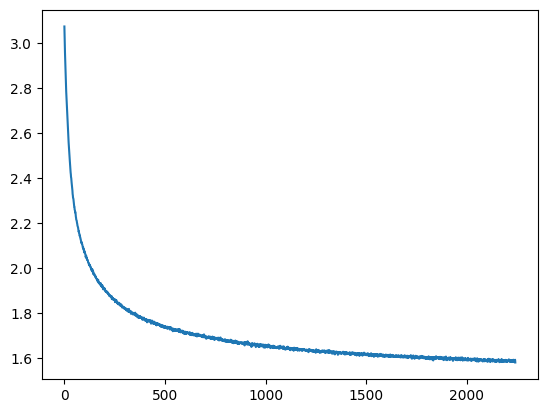

In [30]:
plt.plot(torch.tensor(l).view(-1, 5).mean(dim=-1))